<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/F-principle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tf-nightly-2.0-preview

In [1]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.math import sin
import time
%matplotlib inline
from scipy.fftpack import fft, fftfreq, fftshift
import scipy
from scipy.fftpack import fft
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-alpha0


In [2]:
def f(x):
    return sin(x) + 4 * sin(4*x) - 8 * sin(8*x) + 16 * sin(24*x)

def psy_trial(x, net_out):
    return (-1. - x) * (1. - x) * net_out
  
model = Sequential()
model.add(Dense(128, input_shape=(None, 1), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(0.0005)

nx = 100
x_space = np.linspace(-1, 1, nx).astype('float32').reshape(nx,1)
x_space = tf.constant(x_space)

batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(x_space).batch(batch_size, drop_remainder=True)

example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (16, 1)


# Train

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)
  
@tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x, net_out)

            dy_dx = gg.gradient(psy_t, x)     # gradient
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        
        func = f(x) # right part function
        loss = loss_function(-d2y_dx2, func)
#         print(d2y_dx2)

    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return tf.math.reduce_sum(loss)

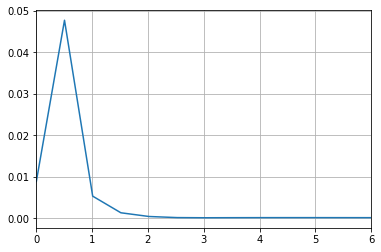

Epoch #0, Loss 1648.119873, Time 0.19 sec


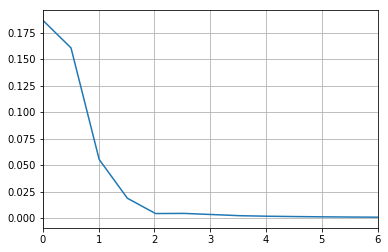

Epoch #100, Loss 1492.914062, Time 0.20 sec


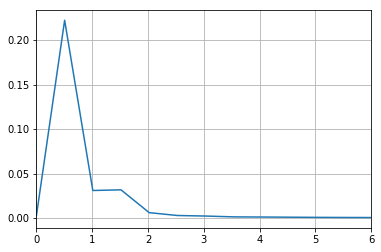

Epoch #200, Loss 1453.211670, Time 0.18 sec


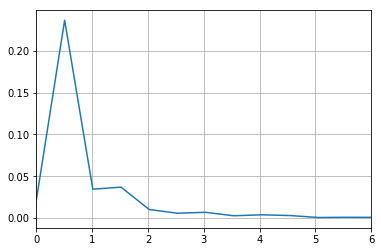

Epoch #300, Loss 1504.575684, Time 0.31 sec


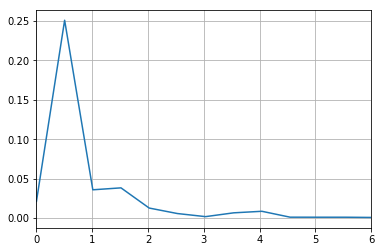

Epoch #400, Loss 1246.096191, Time 0.16 sec


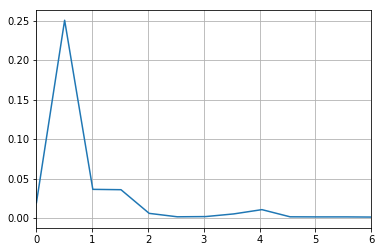

Epoch #500, Loss 835.361450, Time 0.16 sec


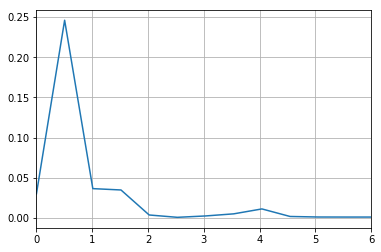

Epoch #600, Loss 357.091644, Time 0.16 sec


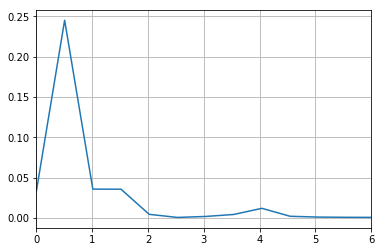

Epoch #700, Loss 108.893410, Time 0.16 sec


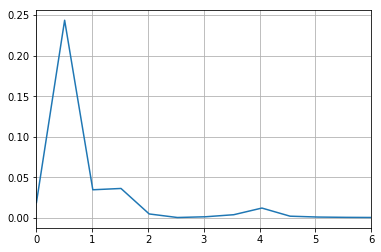

Epoch #800, Loss 65.395256, Time 0.16 sec


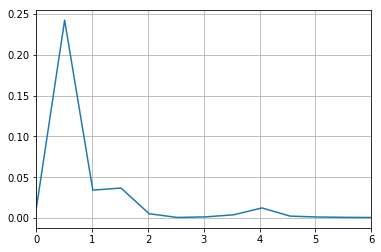

Epoch #900, Loss 49.462868, Time 0.17 sec


In [4]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss = train_on_batch(source_data)
    if epoch % 100 == 0:
#         plt.figure()
        res = psy_trial(x_space, model(x_space)).numpy().reshape(nx)
#         plt.plot(x_space, res)
#         plt.show()
        N = 200
        # sample spacing
        T = 1.0 / 100.0
        yf = fft(res)
        xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        plt.grid()
        plt.xlim(0,6)
        plt.show()        

        print("Epoch #%d, Loss %.6f, Time %.2f sec" % (epoch, loss, time.time() - start))
        
        
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


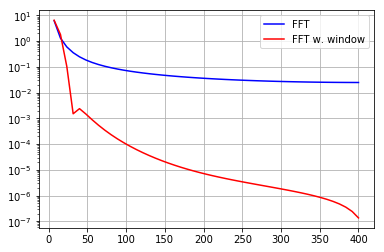

In [0]:

# from scipy.fftpack import fft
# # Number of sample points
# N = 200
# # sample spacing
# T = 1.0 / 100.0
# x = np.linspace(0.0, N*T, N)
# y = sin(x) + 4 * sin(4*x) - 8 * sin(8*x) + 16 * sin(24*x)
# yf = fft(res)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
# import matplotlib.pyplot as plt
# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.grid()
# plt.xlim(0,15)
# plt.show()

from scipy.fftpack import fft
# Number of sample points
N = 100
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(x) + 4 * np.sin(4*x) - 8 * np.sin(8*x) + 16 * np.sin(24*x)
yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(-1, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

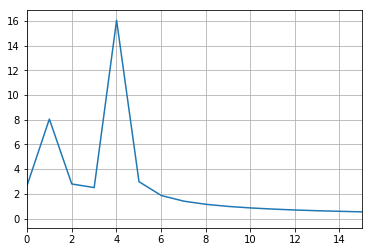

In [0]:
from scipy.fftpack import fft
# Number of sample points
N = 500
# sample spacing
T = 1.0 / 500.0
x = np.linspace(0.0, N*T, N)
y = np.sin(x) + 4*np.sin(4*x) -8*np.sin(8*x) + 16*np.sin(24*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlim(0,15)
plt.show()

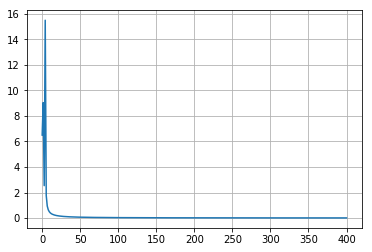

In [0]:
from scipy.fftpack import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(x) + 4*np.sin(4*x) -8*np.sin(8*x) + 16*np.sin(24*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()